# Face Detection Model Training 

**Python 3.11.3** was used for this task.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.image import imread
import matplotlib.patches as patches
from PIL import Image

In [3]:
os.makedirs('FacesDataSet', exist_ok=True)

## 1. Loading and Exploring the Data

In this section, we load the dataset and perform an initial exploration to understand its structure, format, and quality. This includes checking for missing values, visualizing sample images, and verifying the consistency of face detection labels.

The dataset used for this project can be found on [Kaggle](https://www.kaggle.com/datasets/fareselmenshawii/face-detection-dataset). Please download the ZIP file and place it in the `FacesDataSet` directory. Once downloaded, extract the contents using the Python `extractall()` method from the `zipfile` library, as demonstrated below:

In [ ]:
import zipfile

zip_path = os.path.join('FacesDataSet', 'faces.zip')
dataset_path = os.path.join('FacesDataSet', 'faces')

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

In [11]:
dataset_path = os.path.join('FacesDataSet', 'faces')
train_images_path = os.path.join(dataset_path, 'images', 'train')
val_images_path = os.path.join(dataset_path, 'images', 'val')
train_labels_path = os.path.join(dataset_path, 'labels', 'train')
val_labels_path = os.path.join(dataset_path, 'labels', 'val')

Checking if all images have correspoding labels using the `check_image_label_pairs` function.

In [6]:
def check_image_label_pairs(images_path, labels_path, label_extension=".txt"):
    images = sorted(os.listdir(images_path))
    labels = sorted(os.listdir(labels_path))
    
    images = [img for img in images if img.endswith(('.jpg', '.png', '.jpeg'))]
    labels = [lbl for lbl in labels if lbl.endswith(label_extension)]
    
    missing_labels = []
    for img in images:
        label_file = os.path.splitext(img)[0] + label_extension
        if label_file not in labels:
            missing_labels.append(img)
    
    if missing_labels:
        print(f"Missing label files for {len(missing_labels)} images:")
        print(missing_labels)
    else:
        print("All images have corresponding label files.")

print("Checking train set:")
check_image_label_pairs(train_images_path, train_labels_path)

print("\nChecking validation set:")
check_image_label_pairs(val_images_path, val_labels_path)

Checking train set:
All images have corresponding label files.

Checking validation set:
All images have corresponding label files.


Visualizing 10 sample images from the training and validation datasets to inspect the face detection bounding boxes using the `display_images_with_boxes` function.

Train Images with Bounding Boxes:


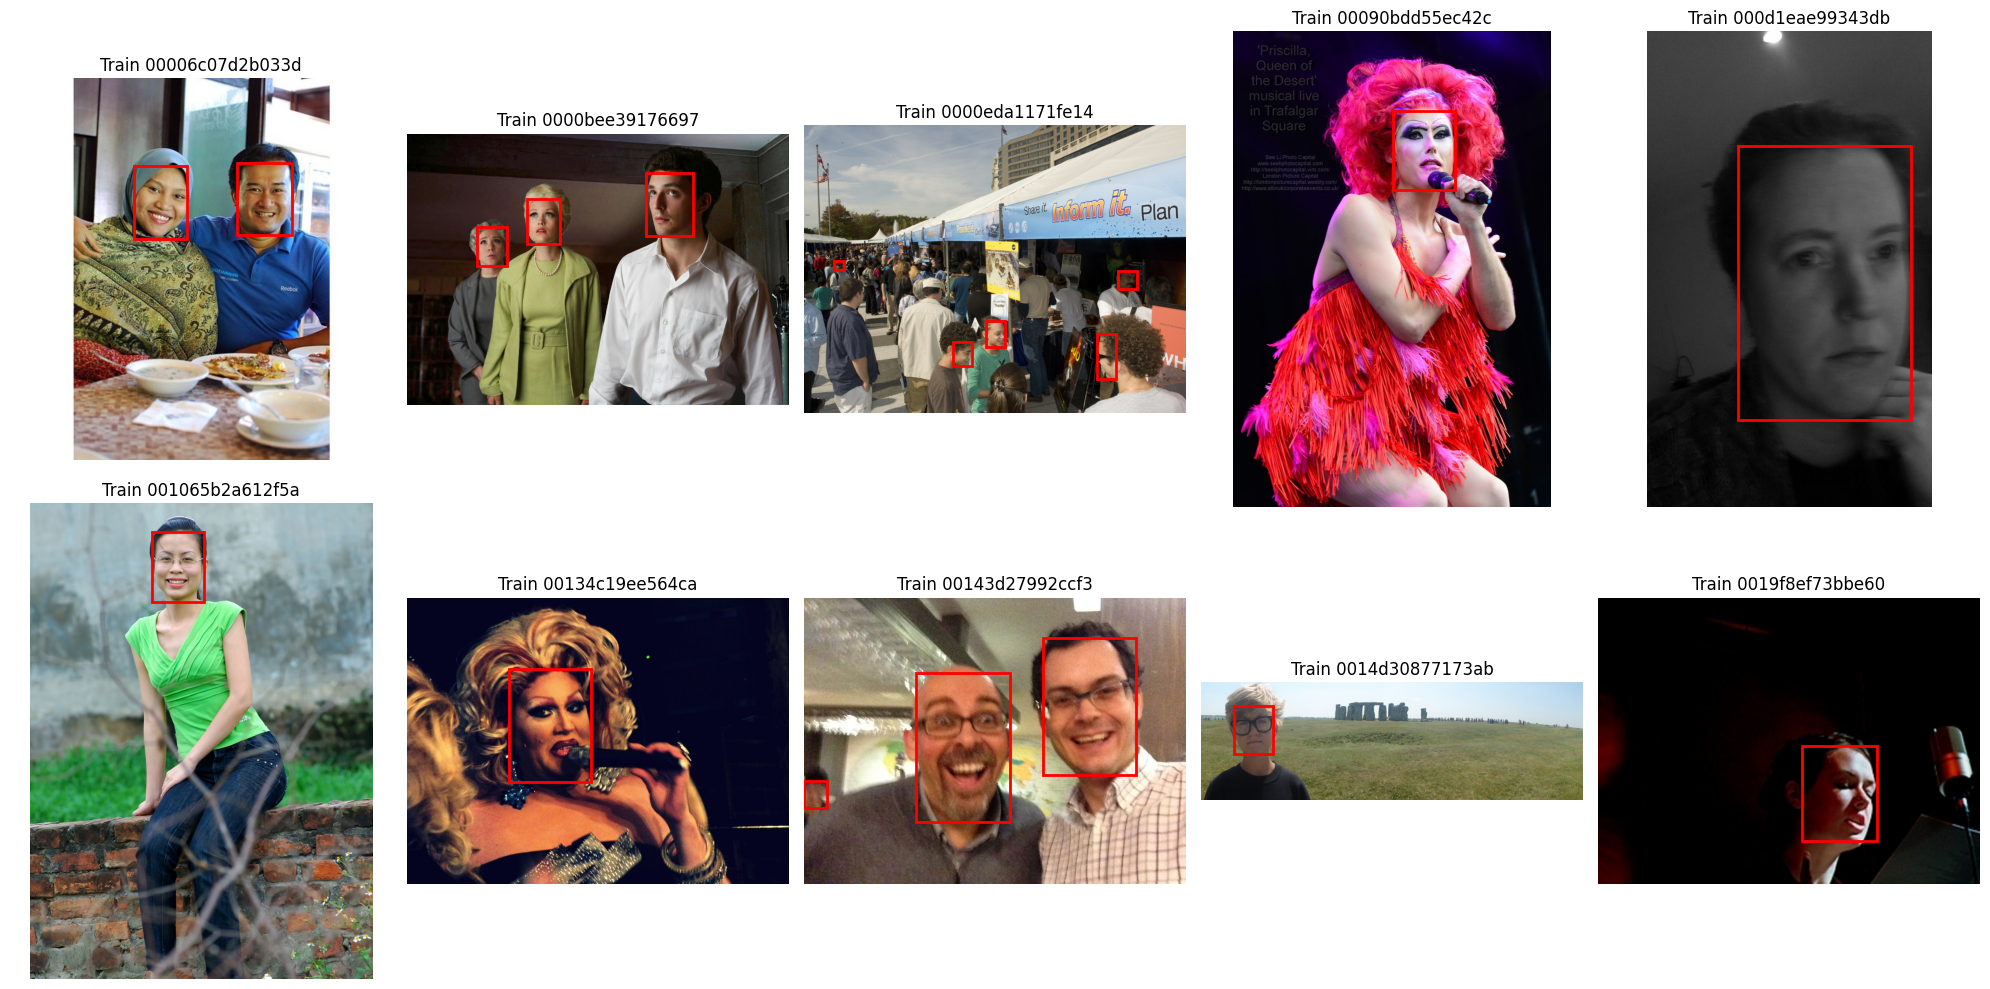


Validation Images with Bounding Boxes:


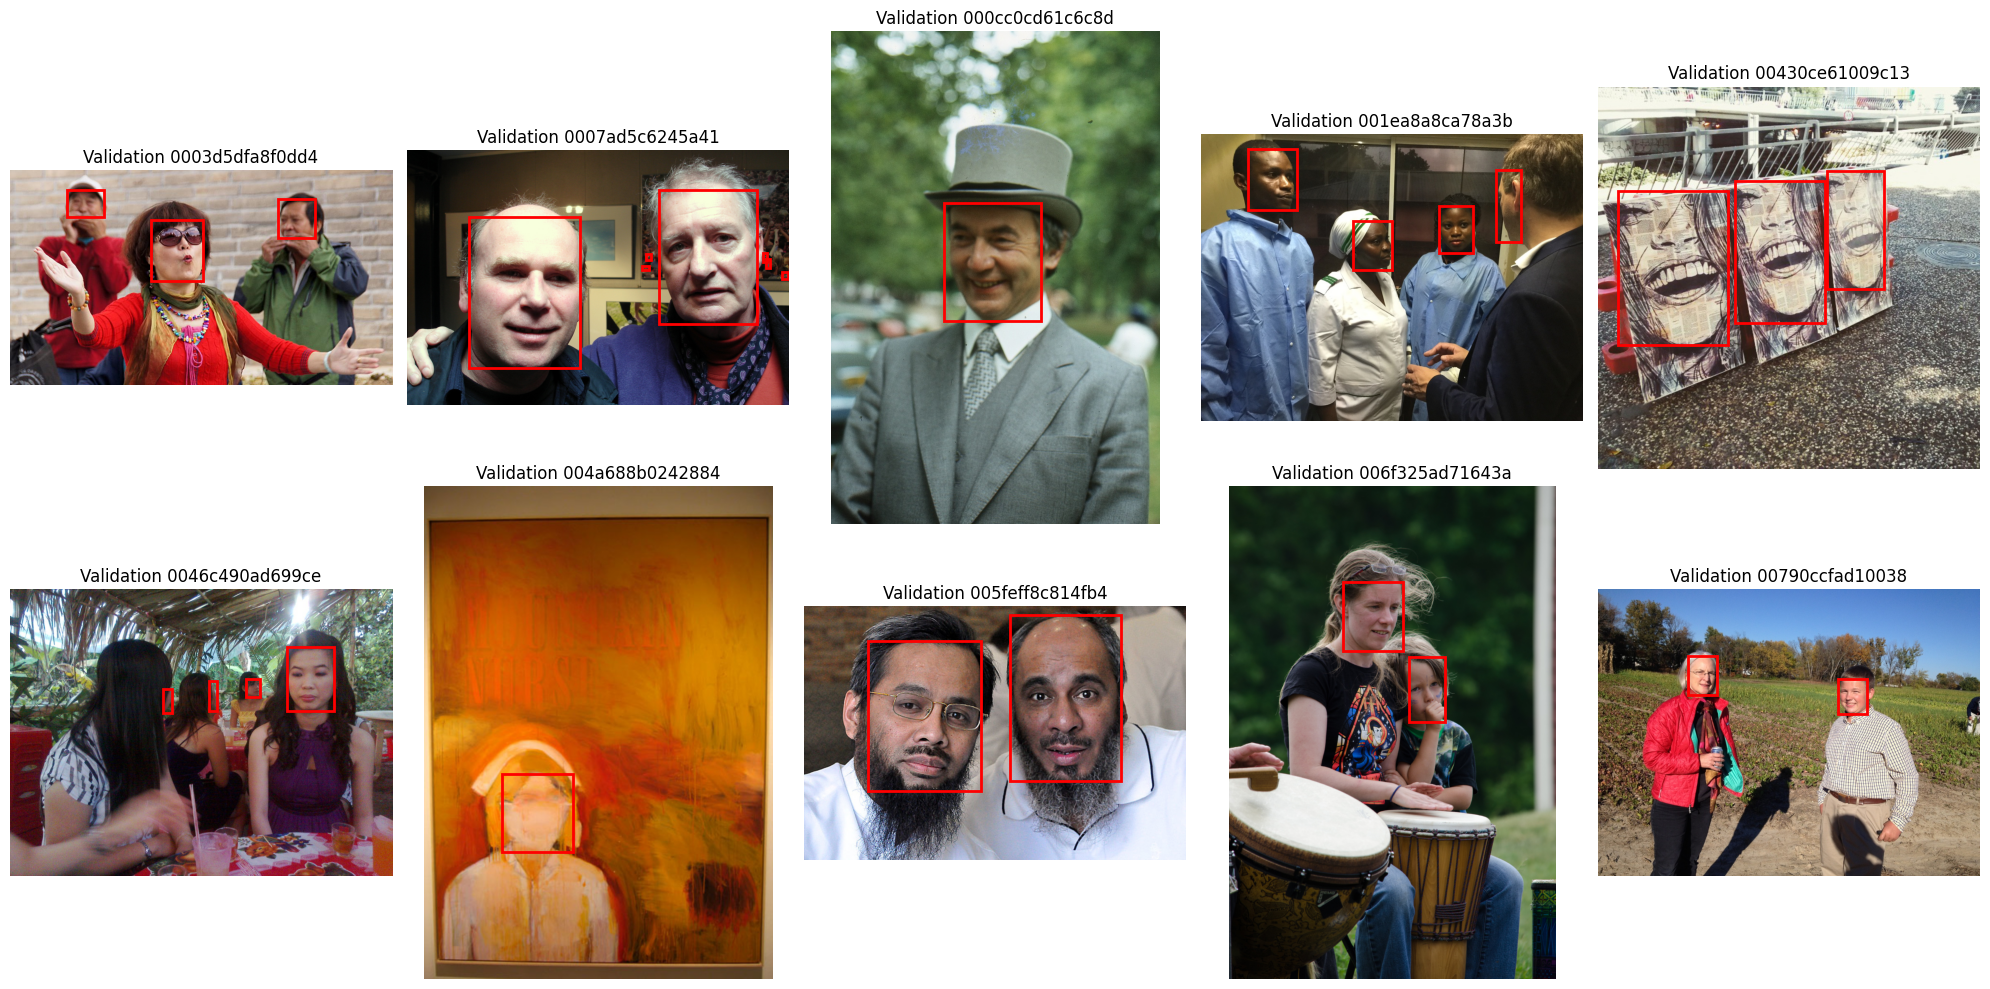

In [9]:
def display_images_with_boxes(image_folder, label_folder, num_images, title_prefix, label_extension=".txt"):
    """
    Display images with bounding boxes, handling multiple faces and class labels.

    Args:
        image_folder (str): Path to the folder containing images.
        label_folder (str): Path to the folder containing label files.
        num_images (int): Number of images to display.
        title_prefix (str): Title prefix for the images.
        label_extension (str): Extension of the label files (default: ".txt").
    """
    plt.figure(figsize=(20, 10))
    images = os.listdir(image_folder)[:num_images]

    for i, filename in enumerate(images):
        image_path = os.path.join(image_folder, filename)
        label_path = os.path.join(label_folder, os.path.splitext(filename)[0] + label_extension)
        image = imread(image_path)
        img_height, img_width = image.shape[:2]

        with open(label_path, "r") as f:
            bboxes = [line.strip().split() for line in f.readlines()]
            bboxes = [[float(coord) for coord in bbox] for bbox in bboxes]

        ax = plt.subplot(2, 5, i + 1)
        ax.imshow(image)
        for bbox in bboxes:
            label, x_center, y_center, width, height = bbox
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height
            x_min = x_center - (width / 2)
            y_min = y_center - (height / 2)
            rect = patches.Rectangle((x_min, y_min), width, height, edgecolor="red", fill=False, linewidth=2)
            ax.add_patch(rect)

        plt.axis("off")
        plt.title(f"{title_prefix} {filename[:15]}")

    plt.tight_layout()
    plt.show()

print("Train Images with Bounding Boxes:")
display_images_with_boxes(train_images_path, train_labels_path, 10, title_prefix="Train")

print("\nValidation Images with Bounding Boxes:")
display_images_with_boxes(val_images_path, val_labels_path, 10, title_prefix="Validation")


## 2. Data Preprocessing

 When training a CNN model, preprocessing typically involves normalizing the images to pixel values within a range of (0, 1) or (-1, +1). However, this step was skipped as the selected YOLOv8n model handles normalization internally.

Instead, the validation dataset was split into two subsets: validation and testing, allowing for a dedicated evaluation of the model's performance during and after training. 

In [46]:
import os
import random
import shutil

images_dir = val_images_path
labels_dir = val_labels_path
output_dir = os.path.join(dataset_path, 'split')

os.makedirs(os.path.join(output_dir, 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'images', 'test'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'labels' ,'val'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'labels', 'test'), exist_ok=True)

images = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
random.shuffle(images)

split_ratio = 0.5
val_split = int(split_ratio * len(images))
val_images = images[:val_split]
test_images = images[val_split:]

def move_files(image_list, subset):
    for image in image_list:
        shutil.copy(os.path.join(images_dir, image), os.path.join(output_dir, f"images/{subset}/{image}"))
        label = image.replace('.jpg', '.txt')
        src_label_path = os.path.join(labels_dir, label)
        dst_label_path = os.path.join(output_dir, f"labels/{subset}/{label}")

        if os.path.exists(src_label_path):
            shutil.copy(src_label_path, dst_label_path)
        else:
            print(f"Warning: Label file {label} not found for image {image}")

move_files(val_images, "val")
move_files(test_images, "test")

## 3. Model Architecture

The [YOLOv8n](https://docs.ultralytics.com/models/yolov8/) model was selected for face detection due to its balance of accuracy and computational efficiency, making it well-suited for this task.

## 4. Training Strategy

### Creating a Dataset Configuration YAML File for YOLOv8

To train a YOLOv8 model on a custom dataset, a **YAML configuration** file is required to define the paths to the dataset and metadata such as the number of classes and their names. This script dynamically generates the YAML file with the necessary details.

**Key Components in the YAML File**
- `train`: Specifies the path to the training dataset.
- `val`: Specifies the path to the validation dataset.
- `test`: Specifies the path to the test dataset.
- `nc`: The number of classes in the dataset.
- `names`: A list of class names corresponding to the classes in the dataset.

In [15]:
import os

dataset_path = os.path.abspath(os.path.join('FacesDataSet', 'faces'))
dataset_path_split = os.path.abspath(os.path.join(dataset_path, 'split'))

train_images_path = os.path.join(dataset_path, 'images', 'train')
val_images_path = os.path.join(dataset_path_split, 'images', 'val')
test_images_path = os.path.join(dataset_path_split, 'images', 'test')

train_labels_path = os.path.join(dataset_path, 'labels', 'train')
val_labels_path = os.path.join(dataset_path_split, 'labels', 'val')
test_labels_path = os.path.join(dataset_path_split, 'labels', 'test')

In [16]:
num_classes = 1
class_names = ["face"]

yaml_content = f"""
train: {train_images_path}
val: {val_images_path}
test: {test_images_path}

nc: {num_classes}
names: {class_names}
"""

dataset_yaml_path = "datasets.yaml"

with open(dataset_yaml_path, "w") as file:
    file.write(yaml_content)


### Training a YOLOv8 Model
The **YOLOv8** model is trained using the `train()` method from the `ultralytics` library with the following key configurations:

- **Model**: The pre-trained YOLOv8 nano model (`yolov8n.pt`) is loaded to leverage its lightweight architecture for fast and efficient training.
- **Data**: A custom dataset is specified using a YAML configuration file (`dataset_yaml_path`).
- **Epochs**: The model is trained for a maximum of 50 epochs.
- **Batch Size**: A batch size of 16 is used for training, ensuring a balance between computational efficiency and stability.
- **Workers**: Set to 4, allowing parallel data loading to speed up training.
- **Device**: Training is performed on GPU 0 for accelerated performance.
- **Patience**: Early stopping is applied with a patience of 10 epochs to halt training if validation metrics do not improve.
- **Project and Name**: Results are saved under the project name `detect_faces` and the specific experiment name `training`.
- **Save**: Training checkpoints and results are saved automatically.

In [22]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

model.train(
    data=dataset_yaml_path,
    epochs=50,
    batch=16,
    workers=4,
    device=0,
    patience=10,
    project='detect_faces',
    name='training',
    save=True
)


KeyboardInterrupt: 

**Model Training Summary**

The model was trained for 50 epochs. However, the cell displays a "Keyboard Interrupted" message because it was mistakenly rerun during the clean coding process. Despite this interruption, the training had already been completed successfully, and the following were saved:

The best model checkpoint.
- Training results and metrics.
- The saved model and results are used for evaluation and further testing. There is no need to rerun the training process.

# 5. Model Evaluation

In [9]:
training_plots_dir = os.path.join('detect_faces', 'training')

def display_plot(image_path, title):
    img = Image.open(image_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()


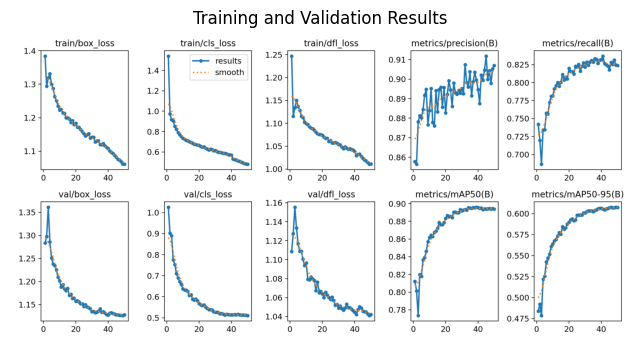

In [50]:
results_plot = os.path.join(training_plots_dir, "results.png")
if os.path.exists(results_plot):
    display_plot(results_plot, "Training and Validation Results")

### Analysis of Training Process
The plots above provide insight into how the training process is progressing for the YOLOv8n model. Let’s analyze them one by one:

- **Box Loss (`box_loss`)**: This metric measures how accurately the predicted bounding boxes align with the ground truth boxes. A declining trend indicates the model is learning effectively.

    - **Training Box Loss**:  
      The plot titled `train/box_loss` shows a steady decline from **1.38** at epoch 0 to **1.02** by epoch 50. This consistent decrease demonstrates that the model is learning to better localize bounding boxes around faces as training progresses. However, the training box loss does not fully converge by epoch 50, suggesting that additional training epochs or a more diverse dataset might further improve the model.

    - **Validation Box Loss**:  
      The plot titled `val/box_loss` shows an overall decline from **1.27** at epoch 0 to **1.10** by epoch 50, indicating the model’s improving generalization ability on unseen data. A temporary spike to **1.37** around epoch 10 likely reflects instability during the early stages of training, as the model adjusts to the dataset. This is followed by a steady decline, with the loss stabilizing around **epoch 30** and converging to **1.11** by epoch 50. The earlier convergence of validation loss compared to training loss suggests that the model may benefit from a larger training dataset to further align the learning curves and enhance performance.

- **Classification Loss (`cls_loss`)**: This metric evaluates how well the model classifies objects (e.g., faces) into the correct category.

    - **Training Classification Loss**:  
      The plot titled `train/cls_loss` shows a significant drop from **1.57** to **0.97** between the first and second epochs, followed by a steady decline over the remaining epochs. By epoch 50, the loss reaches **0.57**, indicating that the model is progressively improving its ability to classify faces correctly as training progresses. The consistent decrease suggests the model is learning effectively.

    - **Validation Classification Loss**:  
      The plot titled `val/cls_loss` demonstrates a noticeable decline from **1.05** at epoch 0 to **0.51** by epoch 50. The decrease appears steep initially but transitions to a more gradual reduction, converging at around epoch 37. Similar to the box loss, the earlier convergence of the validation loss compared to the training loss suggests that the model may benefit from a larger training dataset to further enhance generalization and align the learning curves.

- **Distribution Focal Loss (`dfl_loss`)**: This metric refines bounding box predictions by focusing on precise matches. While it may sound similar to the box loss, the two serve distinct purposes: the box loss handles the "big picture" by aligning the bounding box with the general location of the object, whereas the DFL ensures precise placement of the box edges, improving overall accuracy.

    - **Training Distribution Focal Loss**:  
      The plot titled `train/dfl_loss` shows a steady decline from **1.25** to **1.02** across 50 epochs, with a significant drop from **1.25** to **1.12** between the first and second epochs. A small increase to **1.15** is observed at the third epoch, but the value then resumes a consistent downward trend, reaching **1.02** by epoch 50. This overall decline reflects that the model is becoming increasingly precise in aligning bounding box edges during training. The temporary rise at epoch 3 suggests minor instability in early training, which the model successfully corrected in subsequent epochs.

    - **Validation Distribution Focal Loss**:  
      The plot titled `val/dfl_loss` shows a general downward trend from **1.11** to **1.05** across 50 epochs, but it does not fully converge like some other metrics. After an initial increase from **1.11** to **1.16** during the first three epochs, the loss begins to decrease. This early increase likely reflects instability as the model adjusts to learning precise edge alignment. However, instead of fully stabilizing, the validation loss exhibits slight fluctuations, indicating some inconsistency in the model's ability to generalize precise edge alignment across validation samples. This behavior suggests that while the model improves overall, further adjustments—such as increasing the dataset size or fine-tuning hyperparameters—may be needed to achieve better stability in the validation loss.

- **Precision (`precision(B)`)**:  
    Precision measures the proportion of correct predictions out of all predictions made by the model. It reflects the model’s ability to avoid false positives and is calculated only on the validation dataset. The formula is:  
    $$Precision = \frac{TP}{(TP + FP)}$$
    
    The plot titled `metrics/precision(B)` shows a **converging increase** in precision from **0.86** to **0.91** over 50 epochs. This upward trend indicates that the model is improving its accuracy in identifying faces while reducing false positives as training progresses. While there are small fluctuations of approximately **0.01** throughout the epochs, these fluctuations appear more noticeable due to the relatively narrow range of precision values. Nevertheless, the steady convergence confirms that the model is consistently improving in precision.

- **Recall (`recall(B)`)**:  
    Recall measures the proportion of actual positive objects correctly identified by the model. It reflects the model’s ability to avoid false negatives and is calculated only on the validation dataset. The formula is:  
    $$Recall = \frac{TP}{(TP + FN)}$$

    The plot titled `metrics/recall(B)` shows a **converging increase** in recall from **0.74** to **0.81** across 50 epochs. While there is a slight initial decrease from **0.74** to **0.68** during the first three epochs due to early model adjustments, the model subsequently demonstrates consistent improvement. Recall begins to stabilize around the 25th epoch at **0.82**, with a minor dip to **0.81** after the 40th epoch. This overall convergence indicates that the model is becoming increasingly reliable at avoiding false negatives over time. However, for optimal performance, it would be ideal for recall to converge at a value greater than **0.85**, ensuring stronger generalization and more consistent detection of actual positive objects.

- **Mean Average Precision at IoU 50 (`mAP50`)**:  
    mAP50 measures the model’s ability to accurately detect objects with at least 50% overlap between the predicted and ground truth bounding boxes. It evaluates the precision-recall curve at a single IoU threshold of 50% and is calculated only on the validation dataset. The formula is derived from the area under the precision-recall curve.

    The plot titled `metrics/mAP50(B)` shows an initial drop from **0.82** to **0.78** during the first three epochs, which can be attributed to early model adjustments as the model starts to learn from the data. However, a **converging increase** is observed as mAP50 rises from **0.78** to **0.89** by epoch 35, maintaining this value through epoch 50. This upward trend demonstrates that the model is becoming more robust in detecting faces while maintaining accurate localization. The consistent convergence after epoch 25 further suggests that the model generalizes well to unseen data, ensuring reliable performance.

- **Mean Average Precision across IoU thresholds (`mAP50-95`)**:  
    mAP50-95 is an extension of mAP50, evaluating the model’s detection performance across multiple IoU thresholds ranging from 50% to 95% (in 5% increments). It provides a comprehensive measure of the model's robustness in detecting objects under varying levels of overlap.

    The plot titled `metrics/mAP50-95(B)` shows a **converging increase** from **0.48** at epoch 0 to **0.60** by epoch 35, remaining stable at that value through epoch 50. Although the increase is smaller compared to mAP50, it reflects steady improvement in the model’s ability to detect objects with higher precision under stricter IoU thresholds. This convergence confirms that the model is effectively learning to balance localization and classification across a range of IoU thresholds, demonstrating improved robustness in detecting objects across various levels of overlap.

---

### Final Thoughts 

Overall, the model demonstrates strong learning progress and effective generalization:  

- **Training and validation losses** show a steady decline, indicating the model is improving its ability to **detect and classify faces**.  
- **Precision and recall** trends confirm that the model is becoming more reliable while balancing false positives and false negatives.  
- **mAP metrics** suggest the model effectively detects faces but could benefit from **additional training** or **a more diverse dataset** to improve under stricter localization constraints.  

While the model performs well, further improvements could be made by:  
- **Fine-tuning hyperparameters** for better stability in `dfl_loss`.  
- **Increasing the dataset size** to reduce early instability.  
- **Extending training beyond 50 epochs** to allow full convergence.  

The results suggest that the model is well-trained and stable, making it suitable for further evaluation in real-world applications.  


# 6. Testing

In [7]:
import os
from ultralytics import YOLO

model_path = os.path.join('detect_faces', 'training', 'weights', 'best.pt')
model = YOLO(model_path)

results = model.val(
    data=dataset_yaml_path,
    split="test",
    save=True,
    project="detect_faces",
    name="test_evaluation"
)

Ultralytics 8.3.65  Python-3.11.3 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
val: Scanning D:\ProgressSoftExam\FaceBlur\FacesDataSet\faces\split\labels\test.cache... 1674 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1674/1674 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:19<00:00,  5.42it/s]


                   all       1674       5277      0.901      0.795      0.874       0.58
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to detect_faces\test_evaluation


## Analysis of Test Data

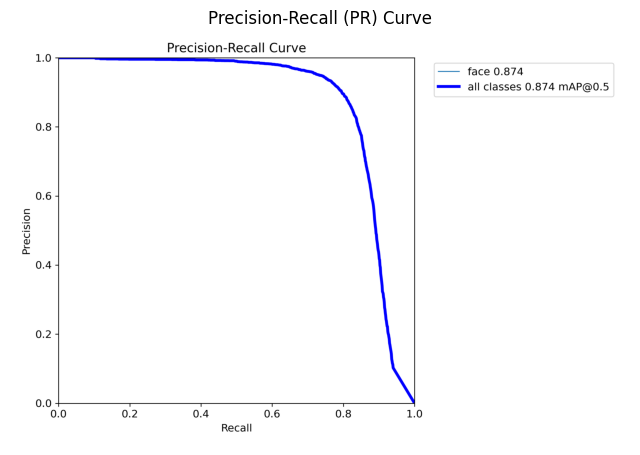

In [12]:
import os

testing_plots_dir = os.path.join('detect_faces', 'test_evaluation')
pr_curve = os.path.join(testing_plots_dir, 'PR_curve.png')

if os.path.exists(pr_curve):
    display_plot(pr_curve, "Precision-Recall (PR) Curve")


**Precision-Recall (PR) Curve Analysis**
- The PR curve illustrates the trade-off between precision and recall for the face class at varying confidence thresholds.
- The model maintains high precision (close to 1.0) for recall values up to approximately 0.8, indicating it can reliably identify faces with minimal false positives within this range.
- After 0.8 recall, precision drops sharply, suggesting that the model begins to struggle with maintaining accuracy while capturing more true positives at lower confidence thresholds.
- The mAP@0.5 score is 0.874, reflecting the overall strong performance of the model in detecting faces across the validation dataset.

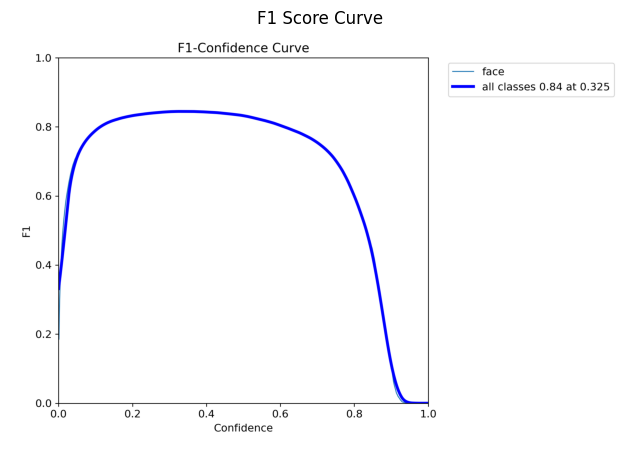

In [13]:
f1_curve = os.path.join(testing_plots_dir, "F1_curve.png")
if os.path.exists(f1_curve):
    display_plot(f1_curve, "F1 Score Curve")

**F1 Score Curve Analysis**
- The F1 Score measures the balance between precision and recall, and this curve illustrates how it changes across varying confidence thresholds.
- The F1 Score peaks at 0.84 for the face class when the confidence threshold is 0.325, indicating this is the optimal threshold for balancing precision and recall in detecting faces.
- At lower confidence thresholds, the F1 Score increases sharply as the model captures more true positives while managing false positives.
- After the peak, the F1 Score gradually declines as the confidence threshold increases, reflecting a decrease in recall due to the model prioritizing higher precision.
- The steep drop near a confidence threshold of 1.0 shows that overly conservative predictions lead to significant losses in recall.

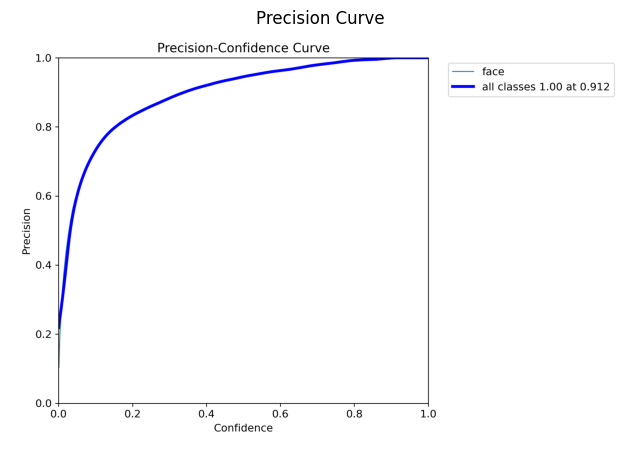

In [14]:
p_curve = os.path.join(testing_plots_dir, "P_curve.png")
if os.path.exists(p_curve):
    display_plot(p_curve, "Precision Curve")

**Precision-Confidence Curve Analysis**
- The Precision-Confidence Curve shows how precision changes with varying confidence thresholds.
- At lower confidence thresholds, precision is relatively low because the model predicts many instances, including false positives.
- As the confidence threshold increases, precision steadily improves, reaching 1.00 at a confidence threshold of 0.912. At this point, the model achieves perfect precision, meaning all predictions made are correct, though this comes at the cost of reduced recall.
- The curve shows a gradual and consistent improvement in precision, indicating the model effectively filters out false positives as the threshold increases.

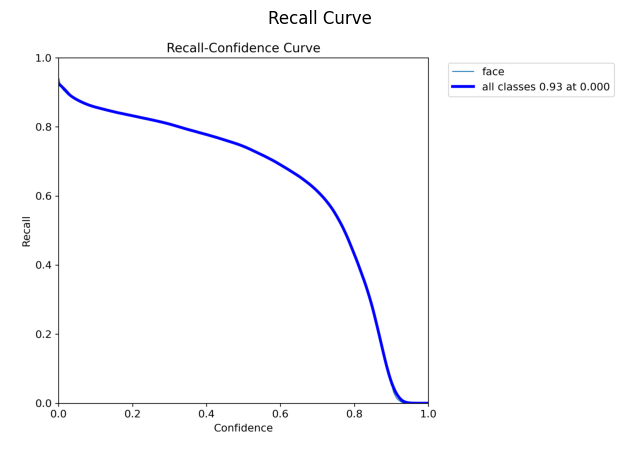

In [15]:
r_curve = os.path.join(testing_plots_dir, "R_curve.png")
if os.path.exists(r_curve):
    display_plot(r_curve, "Recall Curve")

**Recall-Confidence Curve**
- The Recall-Confidence Curve illustrates how recall changes as the confidence threshold increases.
- At lower confidence thresholds (close to 0.0), recall is high, peaking at 0.93 for the face class, as the model captures nearly all true positives, but this may include more false positives.
- As the confidence threshold increases, recall steadily declines, indicating that the model becomes more selective, likely prioritizing precision over recall.
- The drop in recall becomes steeper around a confidence threshold of 0.6, and by 0.9, recall approaches 0.0, as the model becomes overly conservative and stops making predictions unless very confident.

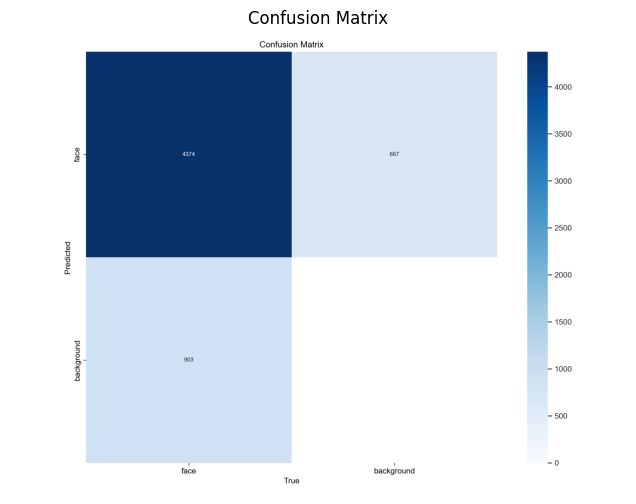

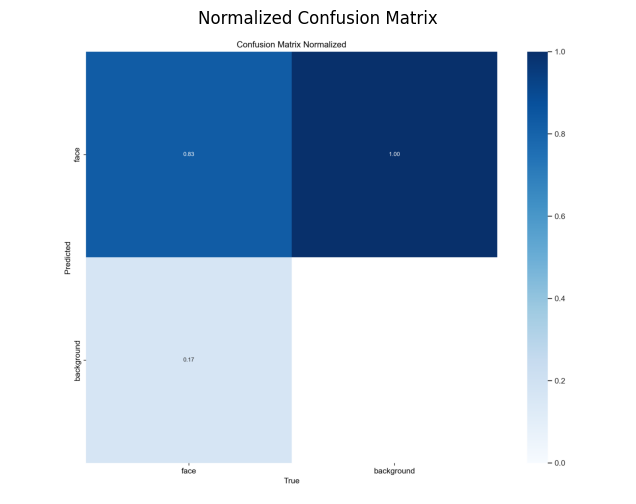

In [24]:
conf_matrix = os.path.join(testing_plots_dir, "confusion_matrix.png")
conf_matrix_norm = os.path.join(testing_plots_dir, "confusion_matrix_normalized.png")
if os.path.exists(conf_matrix):
    display_plot(conf_matrix, "Confusion Matrix")
if os.path.exists(conf_matrix_norm):
    display_plot(conf_matrix_norm, "Normalized Confusion Matrix")

**Confusion Matrix Analysis**:
- The normalized confusion matrix was used as scales the values between 0 and 1, making it easier to compare class-wise performance.
- True Positive Rate (Top Left): The model identifies face correctly in 83% of the cases.
- False Negative Rate (Bottom Left): The model fails to detect face in 17% of actual face cases.
- True Negative Rate (Bottom Right): Perfect detection for the background class (100%), meaning no actual background instances are misclassified as face.

## Visualizing Ground Truth Faces vs Predicted Faces Detected by the Model

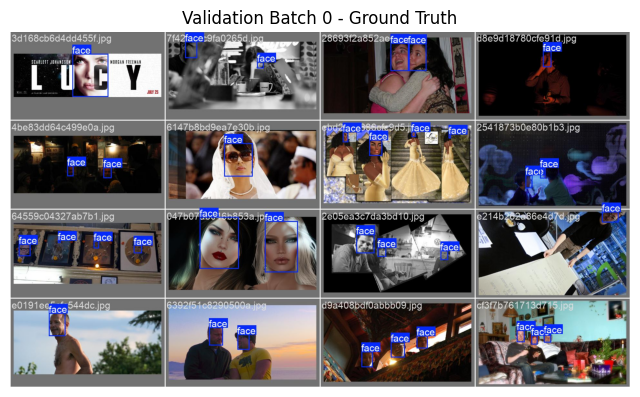

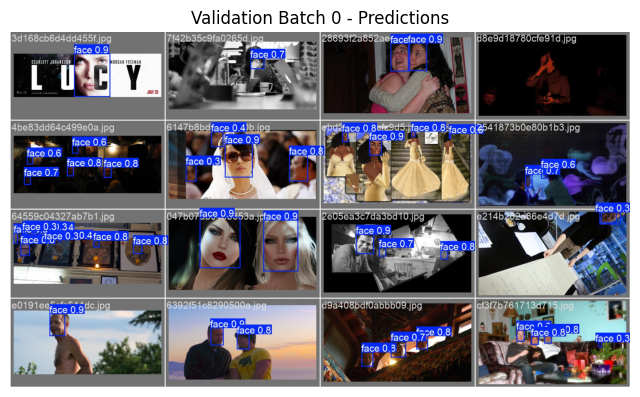

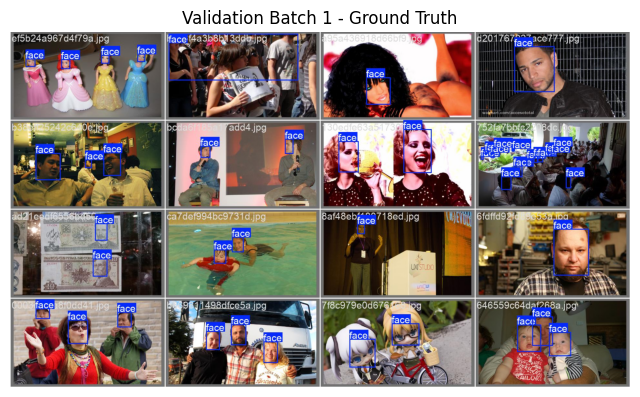

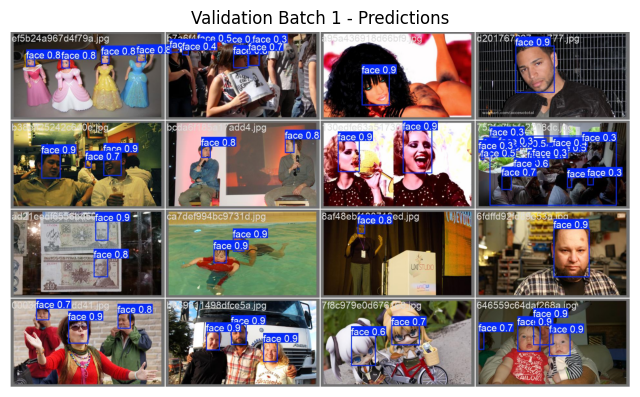

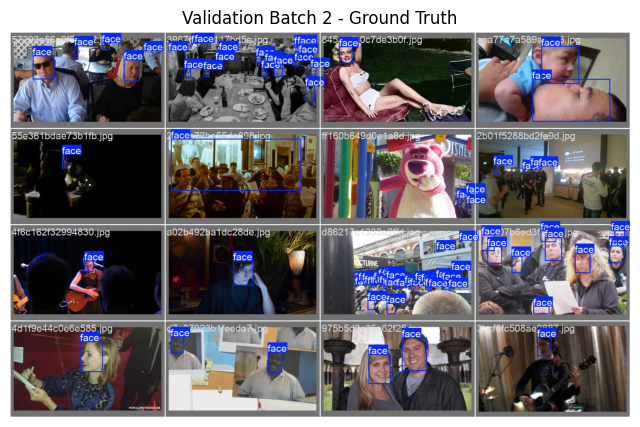

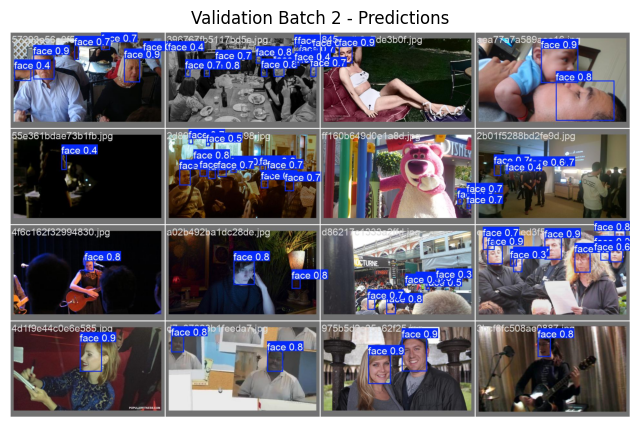

In [20]:
for i in range(3):
    val_labels = os.path.join(testing_plots_dir, f"val_batch{i}_labels.jpg")
    val_preds = os.path.join(testing_plots_dir, f"val_batch{i}_pred.jpg")
    if os.path.exists(val_labels):
        display_plot(val_labels, f"Validation Batch {i} - Ground Truth")
    if os.path.exists(val_preds):
        display_plot(val_preds, f"Validation Batch {i} - Predictions")

# 7. Future Enhancements

- **Fine-Tuning**: Further train the model with augmented data to improve performance on edge cases (e.g., low lighting or occluded faces).
- **Multi-Scale Detection**: Enhance the model to detect faces at varying scales more effectively in complex images.
- **Speed Optimization**: Optimize the model for faster inference, enabling real-time applications.
- **mAP Improvement**: Focus on improving the mAP50-95 score by fine-tuning hyperparameters or experimenting with larger architectures like YOLOv8m.